In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torchinfo import summary
from torch.utils.data import DataLoader
from ArquitecturaHWD import CNN
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix
import seaborn as sns


### MNIST consta de:

Imágenes:

70,000 imágenes en escala de grises (28x28 píxeles).

Las imágenes son dígitos escritos a mano, del 0 al 9.

Está dividido en:

60,000 imágenes para entrenamiento.

10,000 imágenes para prueba.

Etiquetas:

Cada imagen tiene una etiqueta asociada que indica el dígito que representa (un número del 0 al 9).

Estructura del dataset
Formato de las imágenes: Cada imagen es una matriz de 28x28 píxeles, donde cada píxel tiene un valor entre 0 (blanco) y 255 (negro).

Etiquetas: Un número entero entre 0 y 9 que representa el dígito en la imagen.

In [ ]:
transform_aug = transforms.Compose([
    transforms.RandomRotation(20),               # Rotación ±10°
    transforms.RandomAffine(0, translate=(0.15, 0.15),scale=(0.5, 1.2)),  # Desplazamiento 10%
    transforms.ToTensor(), #[0,1]
])

# Para test
transform = transforms.Compose([
    transforms.ToTensor(),
])

#train
train_data = datasets.MNIST(root='data', train=True, transform=transform_aug, download=True)

#val
#train_size = int(0.85 * len(train_data))  
#val_size = len(train_data) - train_size  

#train_data, val_data = random_split(train_data, [train_size, val_size])

#test
test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)

analizando las caracteristicas de los datos


In [107]:
print(test_data,'\n',train_data,'\n')
print(test_data.data.shape)
print(train_data.data.shape)



Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.15, 0.15), scale=(0.5, 1.2))
               ToTensor()
           ) 

torch.Size([10000, 28, 28])
torch.Size([60000, 28, 28])


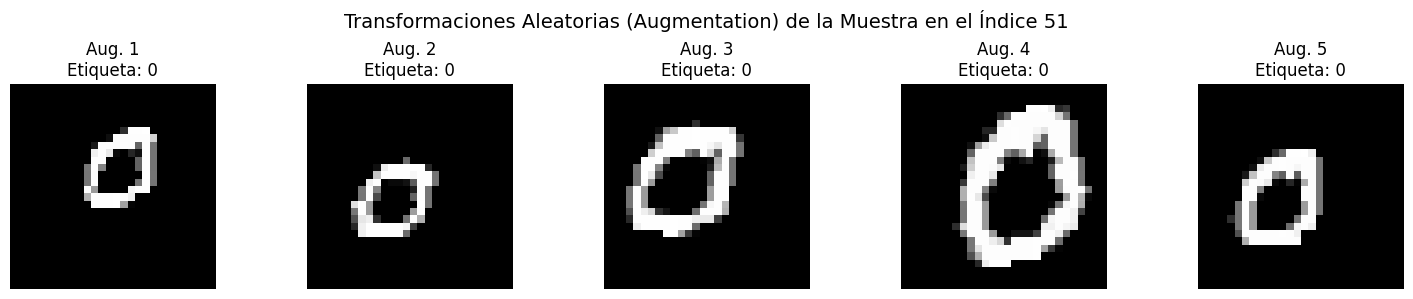

In [111]:
def visualizar_aumento(dataset, indice_original, num_muestras=5):
    """
    Extrae la misma imagen del dataset varias veces para mostrar 
    diferentes transformaciones aleatorias.
    """
    fig, axes = plt.subplots(1, num_muestras, figsize=(15, 3))
    
    # Título principal del gráfico
    fig.suptitle(f"Transformaciones Aleatorias (Augmentation) de la Muestra en el Índice {indice_original}", fontsize=14)

    for i in range(num_muestras):
        # Acceder al dataset aplica una NUEVA transformación aleatoria en cada llamada
        sample, label = dataset[indice_original] 

        # --- Procesamiento para Matplotlib ---
        # 1. Convertir el tensor (C, H, W) a array NumPy (H, W)
        image_np = sample.numpy()
        image_to_show = np.squeeze(image_np) # Quita la dimensión del canal (1)
        
        # 2. Mostrar la imagen
        ax = axes[i]
        # cmap="gray" es necesario para imágenes en blanco y negro
        ax.imshow(image_to_show, cmap="gray")
        ax.set_title(f"Aug. {i+1}\nEtiqueta: {label}")
        ax.axis('off') # Ocultar ejes
        
    plt.tight_layout()
    plt.show()

visualizar_aumento(train_data, indice_original=51, num_muestras=5)

In [ ]:
dataloaders={
    'test':DataLoader(test_data,batch_size=64,shuffle=False,num_workers=2),
    'train':DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2),
}
#num_workers hace que la carga de datos se haga en paralelo

### ¿Por qué se usan capas convolucionales y fully connected juntas?
Las capas convolucionales y fully connected tienen roles complementarios en una red neuronal convolucional (CNN). 

a) Capa convolucional:
Propósito: Extraer características locales y espaciales de la imagen (por ejemplo, bordes, texturas, patrones).

Ventaja: Es invariante a traslaciones, es decir, puede detectar características independientemente de su posición en la imagen.

Limitación: No es eficiente para aprender relaciones globales entre características.

b) Capa fully connected:
Propósito: Combinar las características extraídas por las capas convolucionales para tomar decisiones (por ejemplo, clasificar la imagen).

Ventaja: Puede aprender relaciones complejas entre características globales.

Limitación: Pierde la información espacial y es computacionalmente costosa para datos de alta dimensionalidad (por ejemplo, imágenes grandes).

c) Combinación de ambas:
Las capas convolucionales se usan al principio para extraer características locales y reducir la dimensionalidad de la imagen.

Las capas fully connected se usan al final para combinar estas características y realizar la clasificación

### Funcionamiento de cada capa convolucional
la imagen inicial se pasa como tensor a 10 kernels, y cada kernel genera una nueva imagen procesada (feature map).
Estas 10 imágenes se apilan para formar la salida de la capa convolucional.
Este proceso permite que la red aprenda a detectar múltiples características de la imagen.

## saber mas sobre softmax y sigmoide:
https://towardsdatascience.com/sigmoid-and-softmax-functions-in-5-minutes-f516c80ea1f9/#:~:text=Sigmoid%20is%20used%20for%20binary,extension%20of%20the%20Sigmoid%20function.
 
la sigmoide genera una probabilidad aislada de pertencer o no a una clase <br>
La softmax genera un probabilidad conjunta. Dado un vector, qué porcentaje representa cada elemento dentro del total


In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='model_checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
def Train(stop,model,dataset,optimizer,criterion,epochs=50):
    total_loss_train=[]
    total_loss_eval=[]
    for ep in range(epochs):
        model.train()
        train_loss=0
        for x,y in dataset['train']:
            optimizer.zero_grad()#limpia los gradientes antiguos
            output=model(x)
            loss=criterion(output,y)
            
            loss.backward()#genera unos nuevos
            optimizer.step()#actualiza los pesos
            train_loss += loss.item()
            
        #train loss
        total_loss_train.append(train_loss/len(dataset['train']))
        #eval loss
        eval_loss,accuracy = Eval(model, dataset['test'], criterion) 
        total_loss_eval.append(eval_loss/len(dataset['test']))
    
        stop(eval_loss, model)
        if stop.early_stop:  
            print(f"Early stopping en época {ep+1}\nCargando mejor modelo...")
            break

        if (ep+1)%2==0:
            print(f'Época [{ep+1}/{epochs}]')
            print(f'train:{total_loss_train[-1]:.4f}, eval:{total_loss_eval[-1]:.4f}, precisión: {accuracy:.4f}')
            print('-' * 50)

    return total_loss_train,total_loss_eval

def Eval(model, dataset, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for x, y_true in dataset:
            output = model(x)
            loss = criterion(output, y_true)
            total_loss += loss.item()
            y_pred = output.argmax(dim=1)
            correct += (y_pred == y_true).sum().item()
            total_samples += y_true.size(0)
     
    return (total_loss, 100*correct / total_samples)

def guardar_modelo(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)

def cargar_modelo(path="best_model.pth"):
    model = CNN()
    model.load_state_dict(torch.load(path))
    model.eval()
    
    return model

In [7]:
model=CNN()
#summary(model, input_size=(1, 1, 28, 28))

In [8]:
'''stop = EarlyStopping(patience=5,min_delta=0.001, path='best_model.pth')

optimizer=optim.Adam(model.parameters(),lr=0.001)
loss=nn.CrossEntropyLoss()
train_loss,eval_loss=Train(stop=stop,model=model,dataset=dataloaders,
optimizer=optimizer,criterion=loss,epochs=100)
'''
model=cargar_modelo("best_model.pth")

NameError: name 'train_loss' is not defined

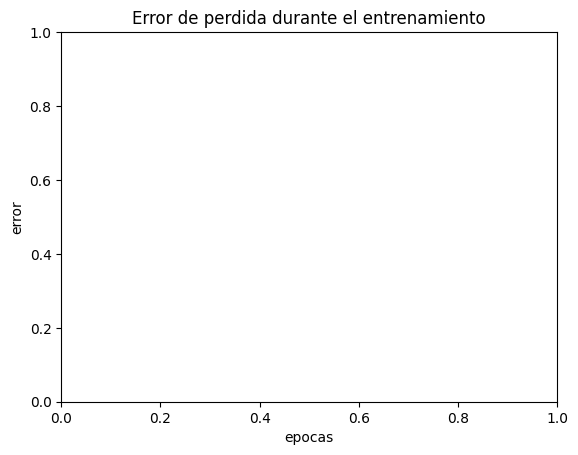

In [ ]:
plt.title('Error de perdida durante el entrenamiento')
plt.ylabel('error')
plt.xlabel('epocas')

plt.plot(np.arange(0, 13),train_loss,label='train')
plt.plot(np.arange(0, 13),eval_loss,label='test')
plt.grid()
plt.legend()
plt.plot()

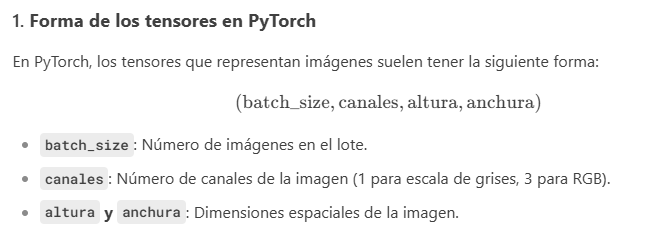

Confusion Matrix:


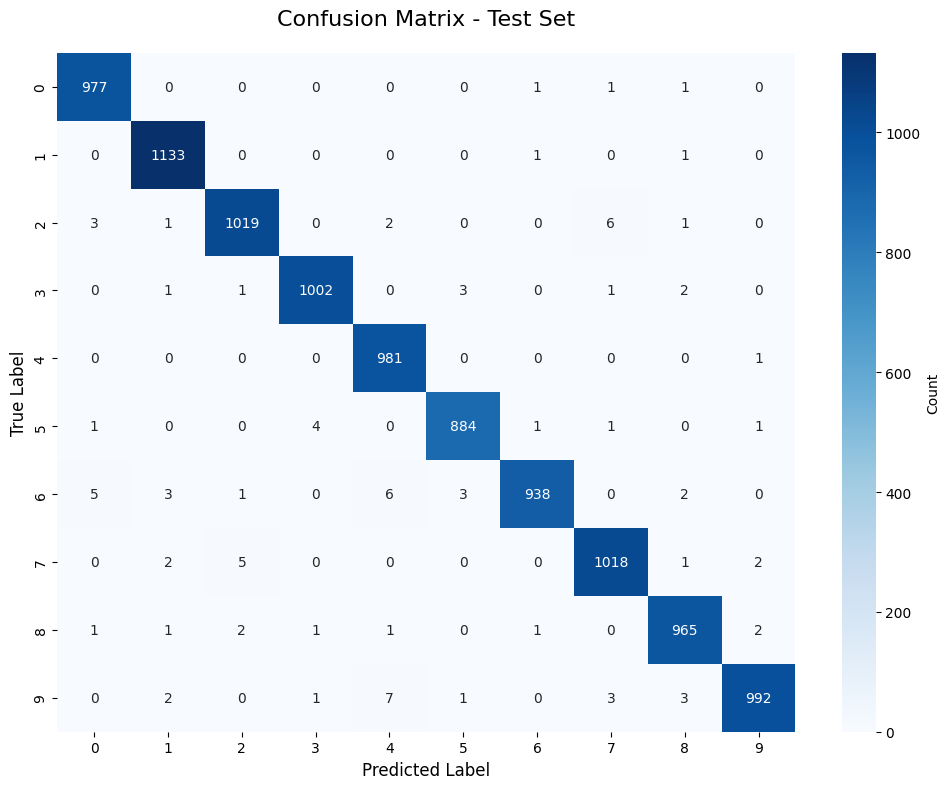

In [10]:
model.eval()
y_true = []
y_pred = []

# Obtener predicciones
with torch.no_grad():
    for x, y in dataloaders['test']:
        output = model(x)
        predictions = output.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
class_names=[0,1,2,3,4,5,6,7,8,9]
print("Confusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()